<a href="https://colab.research.google.com/github/samrudhi93/Build-recommendation-system-using-word2vec/blob/main/Kaggle_Fake_news_classifier_using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, Dropout, Activation , GlobalMaxPooling1D , Embedding
from tensorflow.keras.callbacks import *
import pandas as pd
import nltk


In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
pd.set_option('display.width',1000)
pd.set_option('max_colwidth', 1000) 
import tqdm
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
stpwrds = set(stopwords.words('english'))
stpwrds.discard('not')
stpwrds.discard('no')
import os
import re
from nltk.stem import WordNetLemmatizer as wnl
import sklearn


**Prepping the data**

In [4]:
# Data is fetched and stored in tmp folder with name bbc-text.csv
!wget --no-check-certificate \
    https://storage.googleapis.com/dataset-uploader/bbc/bbc-text.csv \
    -O /tmp/bbc-text.csv

--2021-06-14 06:13:07--  https://storage.googleapis.com/dataset-uploader/bbc/bbc-text.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 74.125.142.128, 173.194.202.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5057493 (4.8M) [text/csv]
Saving to: ‘/tmp/bbc-text.csv’

/tmp/bbc-text.csv   100%[===================>]   4.82M  --.-KB/s    in 0.05s   

2021-06-14 06:13:07 (103 MB/s) - ‘/tmp/bbc-text.csv’ saved [5057493/5057493]



In [5]:
df = pd.read_csv('/tmp/bbc-text.csv' , delimiter = ',')
df.head()

,category,text
0,tech,tv future in the hands of viewers with home theatre systems plasma high-definition tvs and digital video recorders moving into the living room the way people watch tv will be radically different in five years time. that is according to an expert panel which gathered at the annual consumer electronics show in las vegas to discuss how these new technologies will impact one of our favourite pastimes. with the us leading the trend programmes and other content will be delivered to viewers via home networks through cable satellite telecoms companies and broadband service providers to front rooms and portable devices. one of the most talked-about technologies of ces has been digital and personal video recorders (dvr and pvr). these set-top boxes like the us s tivo and the uk s sky+ system allow people to record store play pause and forward wind tv programmes when they want. essentially the technology allows for much more personalised tv. they are also being built-in to h...
1,business,worldcom boss left books alone former worldcom boss bernie ebbers who is accused of overseeing an $11bn (£5.8bn) fraud never made accounting decisions a witness has told jurors. david myers made the comments under questioning by defence lawyers who have been arguing that mr ebbers was not responsible for worldcom s problems. the phone company collapsed in 2002 and prosecutors claim that losses were hidden to protect the firm s shares. mr myers has already pleaded guilty to fraud and is assisting prosecutors. on monday defence lawyer reid weingarten tried to distance his client from the allegations. during cross examination he asked mr myers if he ever knew mr ebbers make an accounting decision . not that i am aware of mr myers replied. did you ever know mr ebbers to make an accounting entry into worldcom books mr weingarten pressed. no replied the witness. mr myers has admitted that he ordered false accounting entries at the request of former worldcom chief fina...
2,sport,tigers wary of farrell gamble leicester say they will not be rushed into making a bid for andy farrell should the great britain rugby league captain decide to switch codes. we and anybody else involved in the process are still some way away from going to the next stage tigers boss john wells told bbc radio leicester. at the moment there are still a lot of unknowns about andy farrell not least his medical situation. whoever does take him on is going to take a big big gamble. farrell who has had persistent knee problems had an operation on his knee five weeks ago and is expected to be out for another three months. leicester and saracens are believed to head the list of rugby union clubs interested in signing farrell if he decides to move to the 15-man game. if he does move across to union wells believes he would better off playing in the backs at least initially. i m sure he could make the step between league and union by being involved in the centre said wells. ...
3,sport,yeading face newcastle in fa cup premiership side newcastle united face a trip to ryman premier league leaders yeading in the fa cup third round. the game - arguably the highlight of the draw - is a potential money-spinner for non-league yeading who beat slough in the second round. conference side exeter city who knocked out doncaster on saturday will travel to old trafford to meet holders manchester united in january. arsenal were drawn at home to stoke and chelsea will play host to scunthorpe. the only other non-league side in the draw are hinckley united who held brentford to a goalless draw on sunday. they will meet league one leaders luton if they win their replay against martin allen s team at griffin park. a number of premiership teams face difficult away games against championship sides on the weekend of 8/9 january. third-placed everton visit plymouth liverpool travel to burnley crystal palace go to sunderland fulham face carling cup semi-finalists watford bolton...
4,entertainment,ocea

In [6]:
df.shape

(2225, 2)

In [7]:
from google.colab import files
uploaded = files.upload()

Saving train.csv to train.csv


In [8]:
import io
df2 = pd.read_csv(io.BytesIO(uploaded['train.csv']))
# Dataset is now stored in a Pandas Dataframe


In [9]:
df2.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It,Darrell Lucus,"House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It By Darrell Lucus on October 30, 2016 Subscribe Jason Chaffetz on the stump in American Fork, Utah ( image courtesy Michael Jolley, available under a Creative Commons-BY license) \nWith apologies to Keith Olbermann, there is no doubt who the Worst Person in The World is this week–FBI Director James Comey. But according to a House Democratic aide, it looks like we also know who the second-worst person is as well. It turns out that when Comey sent his now-infamous letter announcing that the FBI was looking into emails that may be related to Hillary Clinton’s email server, the ranking Democrats on the relevant committees didn’t hear about it from Comey. They found out via a tweet from one of the Republican committee chairmen. \nAs we now know, Comey notified the Republican chairmen and Democratic ranking members of the House Intelligence, Judiciary, and Oversight committees that his agency was reviewing e...",1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - Breitbart",Daniel J. Flynn,"Ever get the feeling your life circles the roundabout rather than heads in a straight line toward the intended destination? [Hillary Clinton remains the big woman on campus in leafy, liberal Wellesley, Massachusetts. Everywhere else votes her most likely to don her inauguration dress for the remainder of her days the way Miss Havisham forever wore that wedding dress. Speaking of Great Expectations, Hillary Rodham overflowed with them 48 years ago when she first addressed a Wellesley graduating class. The president of the college informed those gathered in 1969 that the students needed “no debate so far as I could ascertain as to who their spokesman was to be” (kind of the like the Democratic primaries in 2016 minus the terms unknown then even at a Seven Sisters school). “I am very glad that Miss Adams made it clear that what I am speaking for today is all of us — the 400 of us,” Miss Rodham told her classmates. After appointing herself Edger Bergen to the Charlie McCarthys and ...",0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, 2016 \nThe tension between intelligence analysts and political policymakers has always been between honest assessments and desired results, with the latter often overwhelming the former, as in the Iraq War, writes Lawrence Davidson. \nBy Lawrence Davidson \nFor those who might wonder why foreign policy makers repeatedly make bad choices, some insight might be drawn from the following analysis. The action here plays out in the United States, but the lessons are probably universal. \nBack in the early spring of 2003, George W. Bush initiated the invasion of Iraq. One of his key public reasons for doing so was the claim that the country’s dictator, Saddam Hussein, was on the verge of developing nuclear weapons and was hiding other weapons of mass destruction. The real reason went beyond that charge and included a long-range plan for “regime change” in the Middle East. President George W. Bush and Vice President Dick Cheney receive an Oval ...",1
3,3,15 Civilians Killed In Single US Airstrike Have Been Identified,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstrike Have Been Identified The rate at which civilians are being killed by American airstrikes in Afghanistan is now higher than it was in 2014 when the US was engaged in active combat operations. Photo of Hellfire missiles being loaded onto a US military Reaper drone in Afghanistan by Staff Sgt. Brian Ferguson/U.S. Air Force. \nThe Bureau has been able to identify 15 civilians killed in a single US drone strike in Afghanistan last month – the biggest loss of civilian life in one strike since the attack on the Medecins Sans Frontieres hospital (MSF) last October. \nThe US claimed it had conduct

In [10]:
df2.columns

Index(['id', 'title', 'author', 'text', 'label'], dtype='object')

In [11]:
df2.shape

(20800, 5)

In [12]:
df2.head(3)

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It,Darrell Lucus,"House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It By Darrell Lucus on October 30, 2016 Subscribe Jason Chaffetz on the stump in American Fork, Utah ( image courtesy Michael Jolley, available under a Creative Commons-BY license) \nWith apologies to Keith Olbermann, there is no doubt who the Worst Person in The World is this week–FBI Director James Comey. But according to a House Democratic aide, it looks like we also know who the second-worst person is as well. It turns out that when Comey sent his now-infamous letter announcing that the FBI was looking into emails that may be related to Hillary Clinton’s email server, the ranking Democrats on the relevant committees didn’t hear about it from Comey. They found out via a tweet from one of the Republican committee chairmen. \nAs we now know, Comey notified the Republican chairmen and Democratic ranking members of the House Intelligence, Judiciary, and Oversight committees that his agency was reviewing e...",1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - Breitbart",Daniel J. Flynn,"Ever get the feeling your life circles the roundabout rather than heads in a straight line toward the intended destination? [Hillary Clinton remains the big woman on campus in leafy, liberal Wellesley, Massachusetts. Everywhere else votes her most likely to don her inauguration dress for the remainder of her days the way Miss Havisham forever wore that wedding dress. Speaking of Great Expectations, Hillary Rodham overflowed with them 48 years ago when she first addressed a Wellesley graduating class. The president of the college informed those gathered in 1969 that the students needed “no debate so far as I could ascertain as to who their spokesman was to be” (kind of the like the Democratic primaries in 2016 minus the terms unknown then even at a Seven Sisters school). “I am very glad that Miss Adams made it clear that what I am speaking for today is all of us — the 400 of us,” Miss Rodham told her classmates. After appointing herself Edger Bergen to the Charlie McCarthys and ...",0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, 2016 \nThe tension between intelligence analysts and political policymakers has always been between honest assessments and desired results, with the latter often overwhelming the former, as in the Iraq War, writes Lawrence Davidson. \nBy Lawrence Davidson \nFor those who might wonder why foreign policy makers repeatedly make bad choices, some insight might be drawn from the following analysis. The action here plays out in the United States, but the lessons are probably universal. \nBack in the early spring of 2003, George W. Bush initiated the invasion of Iraq. One of his key public reasons for doing so was the claim that the country’s dictator, Saddam Hussein, was on the verge of developing nuclear weapons and was hiding other weapons of mass destruction. The real reason went beyond that charge and included a long-range plan for “regime change” in the Middle East. President George W. Bush and Vice President Dick Cheney receive an Oval ...",1


In [13]:
df2.label.value_counts()

1    10413
0    10387
Name: label, dtype: int64

In [14]:
df2.dropna()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It,Darrell Lucus,"House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It By Darrell Lucus on October 30, 2016 Subscribe Jason Chaffetz on the stump in American Fork, Utah ( image courtesy Michael Jolley, available under a Creative Commons-BY license) \nWith apologies to Keith Olbermann, there is no doubt who the Worst Person in The World is this week–FBI Director James Comey. But according to a House Democratic aide, it looks like we also know who the second-worst person is as well. It turns out that when Comey sent his now-infamous letter announcing that the FBI was looking into emails that may be related to Hillary Clinton’s email server, the ranking Democrats on the relevant committees didn’t hear about it from Comey. They found out via a tweet from one of the Republican committee chairmen. \nAs we now know, Comey notified the Republican chairmen and Democratic ranking members of the House Intelligence, Judiciary, and Oversight committees that his agency was reviewing e...",1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - Breitbart",Daniel J. Flynn,"Ever get the feeling your life circles the roundabout rather than heads in a straight line toward the intended destination? [Hillary Clinton remains the big woman on campus in leafy, liberal Wellesley, Massachusetts. Everywhere else votes her most likely to don her inauguration dress for the remainder of her days the way Miss Havisham forever wore that wedding dress. Speaking of Great Expectations, Hillary Rodham overflowed with them 48 years ago when she first addressed a Wellesley graduating class. The president of the college informed those gathered in 1969 that the students needed “no debate so far as I could ascertain as to who their spokesman was to be” (kind of the like the Democratic primaries in 2016 minus the terms unknown then even at a Seven Sisters school). “I am very glad that Miss Adams made it clear that what I am speaking for today is all of us — the 400 of us,” Miss Rodham told her classmates. After appointing herself Edger Bergen to the Charlie McCarthys and ...",0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, 2016 \nThe tension between intelligence analysts and political policymakers has always been between honest assessments and desired results, with the latter often overwhelming the former, as in the Iraq War, writes Lawrence Davidson. \nBy Lawrence Davidson \nFor those who might wonder why foreign policy makers repeatedly make bad choices, some insight might be drawn from the following analysis. The action here plays out in the United States, but the lessons are probably universal. \nBack in the early spring of 2003, George W. Bush initiated the invasion of Iraq. One of his key public reasons for doing so was the claim that the country’s dictator, Saddam Hussein, was on the verge of developing nuclear weapons and was hiding other weapons of mass destruction. The real reason went beyond that charge and included a long-range plan for “regime change” in the Middle East. President George W. Bush and Vice President Dick Cheney receive an Oval ...",1
3,3,15 Civilians Killed In Single US Airstrike Have Been Identified,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstrike Have Been Identified The rate at which civilians are being killed by American airstrikes in Afghanistan is now higher than it was in 2014 when the US was engaged in active combat operations. Photo of Hellfire missiles being loaded onto a US military Reaper drone in Afghanistan by Staff Sgt. Brian Ferguson/U.S. Air Force. \nThe Bureau has been able to identify 15 civilians killed in a single US drone strike in Afghanistan last month – the biggest loss of civilian life in one strike since the attack on the Medecins Sans Frontieres hospital (MSF) last October. \nThe US claimed it had conduct

In [15]:
X = df2.drop('label', axis=1)
X.head()

,id,title,author,text
0,0,House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It,Darrell Lucus,"House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It By Darrell Lucus on October 30, 2016 Subscribe Jason Chaffetz on the stump in American Fork, Utah ( image courtesy Michael Jolley, available under a Creative Commons-BY license) \nWith apologies to Keith Olbermann, there is no doubt who the Worst Person in The World is this week–FBI Director James Comey. But according to a House Democratic aide, it looks like we also know who the second-worst person is as well. It turns out that when Comey sent his now-infamous letter announcing that the FBI was looking into emails that may be related to Hillary Clinton’s email server, the ranking Democrats on the relevant committees didn’t hear about it from Comey. They found out via a tweet from one of the Republican committee chairmen. \nAs we now know, Comey notified the Republican chairmen and Democratic ranking members of the House Intelligence, Judiciary, and Oversight committees that his agency was reviewing e..."
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - Breitbart",Daniel J. Flynn,"Ever get the feeling your life circles the roundabout rather than heads in a straight line toward the intended destination? [Hillary Clinton remains the big woman on campus in leafy, liberal Wellesley, Massachusetts. Everywhere else votes her most likely to don her inauguration dress for the remainder of her days the way Miss Havisham forever wore that wedding dress. Speaking of Great Expectations, Hillary Rodham overflowed with them 48 years ago when she first addressed a Wellesley graduating class. The president of the college informed those gathered in 1969 that the students needed “no debate so far as I could ascertain as to who their spokesman was to be” (kind of the like the Democratic primaries in 2016 minus the terms unknown then even at a Seven Sisters school). “I am very glad that Miss Adams made it clear that what I am speaking for today is all of us — the 400 of us,” Miss Rodham told her classmates. After appointing herself Edger Bergen to the Charlie McCarthys and ..."
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, 2016 \nThe tension between intelligence analysts and political policymakers has always been between honest assessments and desired results, with the latter often overwhelming the former, as in the Iraq War, writes Lawrence Davidson. \nBy Lawrence Davidson \nFor those who might wonder why foreign policy makers repeatedly make bad choices, some insight might be drawn from the following analysis. The action here plays out in the United States, but the lessons are probably universal. \nBack in the early spring of 2003, George W. Bush initiated the invasion of Iraq. One of his key public reasons for doing so was the claim that the country’s dictator, Saddam Hussein, was on the verge of developing nuclear weapons and was hiding other weapons of mass destruction. The real reason went beyond that charge and included a long-range plan for “regime change” in the Middle East. President George W. Bush and Vice President Dick Cheney receive an Oval ..."
3,3,15 Civilians Killed In Single US Airstrike Have Been Identified,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstrike Have Been Identified The rate at which civilians are being killed by American airstrikes in Afghanistan is now higher than it was in 2014 when the US was engaged in active combat operations. Photo of Hellfire missiles being loaded onto a US military Reaper drone in Afghanistan by Staff Sgt. Brian Ferguson/U.S. Air Force. \nThe Bureau has been able to identify 15 civilians killed in a single US drone strike in Afghanistan last month – the biggest loss of civilian life in one strike since the attack on the Medecins Sans Frontieres hospital (MSF) last October. \nThe US claimed it had conducted a “counte

In [16]:
y = df2['label']
y.head()

0    1
1    0
2    1
3    1
4    1
Name: label, dtype: int64

In [17]:
X.shape

(20800, 4)

In [18]:
y.shape

(20800,)

In [19]:
import tensorflow as tf

In [20]:
tf.__version__

'2.5.0'

In [21]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

### One hot representation

# New Section

In [22]:
voc_size=5000

In [23]:
messages= X.copy()

In [24]:
messages['title'][1]

'FLYNN: Hillary Clinton, Big Woman on Campus - Breitbart'

In [25]:
messages

,id,title,author,text
0,0,House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It,Darrell Lucus,"House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It By Darrell Lucus on October 30, 2016 Subscribe Jason Chaffetz on the stump in American Fork, Utah ( image courtesy Michael Jolley, available under a Creative Commons-BY license) \nWith apologies to Keith Olbermann, there is no doubt who the Worst Person in The World is this week–FBI Director James Comey. But according to a House Democratic aide, it looks like we also know who the second-worst person is as well. It turns out that when Comey sent his now-infamous letter announcing that the FBI was looking into emails that may be related to Hillary Clinton’s email server, the ranking Democrats on the relevant committees didn’t hear about it from Comey. They found out via a tweet from one of the Republican committee chairmen. \nAs we now know, Comey notified the Republican chairmen and Democratic ranking members of the House Intelligence, Judiciary, and Oversight committees that his agency was reviewing e..."
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - Breitbart",Daniel J. Flynn,"Ever get the feeling your life circles the roundabout rather than heads in a straight line toward the intended destination? [Hillary Clinton remains the big woman on campus in leafy, liberal Wellesley, Massachusetts. Everywhere else votes her most likely to don her inauguration dress for the remainder of her days the way Miss Havisham forever wore that wedding dress. Speaking of Great Expectations, Hillary Rodham overflowed with them 48 years ago when she first addressed a Wellesley graduating class. The president of the college informed those gathered in 1969 that the students needed “no debate so far as I could ascertain as to who their spokesman was to be” (kind of the like the Democratic primaries in 2016 minus the terms unknown then even at a Seven Sisters school). “I am very glad that Miss Adams made it clear that what I am speaking for today is all of us — the 400 of us,” Miss Rodham told her classmates. After appointing herself Edger Bergen to the Charlie McCarthys and ..."
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, 2016 \nThe tension between intelligence analysts and political policymakers has always been between honest assessments and desired results, with the latter often overwhelming the former, as in the Iraq War, writes Lawrence Davidson. \nBy Lawrence Davidson \nFor those who might wonder why foreign policy makers repeatedly make bad choices, some insight might be drawn from the following analysis. The action here plays out in the United States, but the lessons are probably universal. \nBack in the early spring of 2003, George W. Bush initiated the invasion of Iraq. One of his key public reasons for doing so was the claim that the country’s dictator, Saddam Hussein, was on the verge of developing nuclear weapons and was hiding other weapons of mass destruction. The real reason went beyond that charge and included a long-range plan for “regime change” in the Middle East. President George W. Bush and Vice President Dick Cheney receive an Oval ..."
3,3,15 Civilians Killed In Single US Airstrike Have Been Identified,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstrike Have Been Identified The rate at which civilians are being killed by American airstrikes in Afghanistan is now higher than it was in 2014 when the US was engaged in active combat operations. Photo of Hellfire missiles being loaded onto a US military Reaper drone in Afghanistan by Staff Sgt. Brian Ferguson/U.S. Air Force. \nThe Bureau has been able to identify 15 civilians killed in a single US drone strike in Afghanistan last month – the biggest loss of civilian life in one strike since the attack on the Medecins Sans Frontieres hospital (MSF) last October. \nThe US claimed it had conducted a “counte

In [26]:
messages.reset_index(inplace=True)

In [27]:
import nltk
import re
from nltk.corpus import stopwords

In [28]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [29]:
df2['text'][0:10]

0    House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It By Darrell Lucus on October 30, 2016 Subscribe Jason Chaffetz on the stump in American Fork, Utah ( image courtesy Michael Jolley, available under a Creative Commons-BY license) \nWith apologies to Keith Olbermann, there is no doubt who the Worst Person in The World is this week–FBI Director James Comey. But according to a House Democratic aide, it looks like we also know who the second-worst person is as well. It turns out that when Comey sent his now-infamous letter announcing that the FBI was looking into emails that may be related to Hillary Clinton’s email server, the ranking Democrats on the relevant committees didn’t hear about it from Comey. They found out via a tweet from one of the Republican committee chairmen. \nAs we now know, Comey notified the Republican chairmen and Democratic ranking members of the House Intelligence, Judiciary, and Oversight committees that his agency was reviewing 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


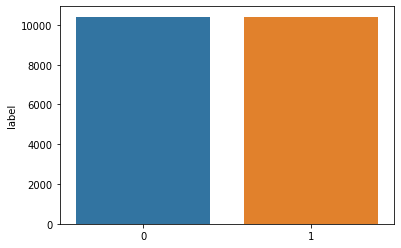

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
x = df2['label'].value_counts()
sns.barplot(x.index , x)
plt.show()

TypeError: ignored

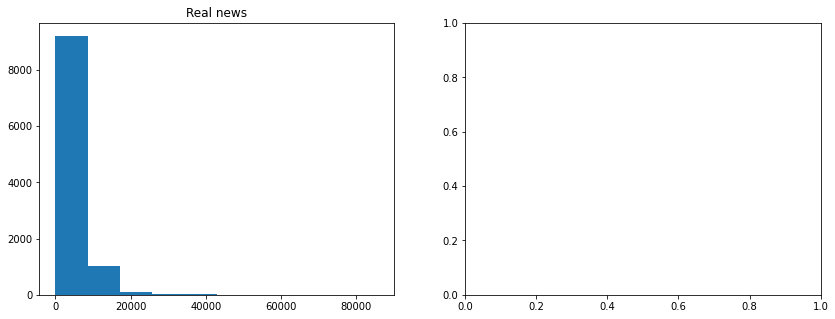

In [31]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(14,5))
tweet_len = df2[df2['label'] == 0]['text'].apply(lambda x : len(x))
ax1.hist(tweet_len )
ax1.set_title('Real news')

tweet_len2 = df2[df2['label'] == 1]['text'].apply(lambda x : len(x))
ax2.hist(tweet_len2)
ax2.set_title('Fake news')

fig.suptitle('Tweets (overall)-length')
plt.show()

In [ ]:
df2['label'].dtypes

In [ ]:
tweet_len2 = df2[df2['label'] == float(1)]['text'].apply(lambda x : len(x))
ax2.hist(tweet_len2)
ax2.set_title('Fake news')

fig.suptitle('Tweets (overall)-length')
plt.show()

In [ ]:
plt.figure(figsize=(7,7))

value_count = df2["label"].value_counts()


plt.pie(value_count, labels=value_count.index ,
        startangle = 90 ,counterclock =False, wedgeprops = {'width' : 0.6},
        autopct='%1.1f%%', pctdistance = 0.7, textprops = {'color': 'black', 'fontsize' : 18}, 
        shadow = True,colors = sns.color_palette("Paired")[7:])
plt.text(x = -0.25, y=0,s ="Total :{}".format(df2.shape[0]))
plt.title("Venn diagram",size=15)

In [ ]:
df2.head()

In [ ]:
from wordcloud import WordCloud

fake = df2[df2['label'] == int(0)]['text']
cloud = fake.tolist()
cloud_st = " ".join(cloud)
plt.figure(figsize=(10,10))
plt.imshow(WordCloud().generate(cloud_st))
plt.axis("off")

In [ ]:
fake = df2[df2['label'] == int(1)]['text']
cloud = fake.tolist()
cloud_st = " ".join(cloud)
plt.figure(figsize=(10,10))
plt.imshow(WordCloud().generate(cloud_st))
plt.axis("off")

In [ ]:
df2[df2['label'] == int(1)]

In [1]:
!cat /proc/meminfo

MemTotal:       13305368 kB
MemFree:        10706096 kB
MemAvailable:   12518716 kB
Buffers:           84708 kB
Cached:          1869088 kB
SwapCached:            0 kB
Active:           953768 kB
Inactive:        1399916 kB
Active(anon):     369664 kB
Inactive(anon):      432 kB
Active(file):     584104 kB
Inactive(file):  1399484 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:               188 kB
Writeback:             0 kB
AnonPages:        399924 kB
Mapped:           237780 kB
Shmem:              1144 kB
KReclaimable:     141016 kB
Slab:             186076 kB
SReclaimable:     141016 kB
SUnreclaim:        45060 kB
KernelStack:        4832 kB
PageTables:         5492 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6652684 kB
Committed_AS:    3219108 kB
VmallocTotal:   34359738367 kB
VmallocUsed:        7172 kB
VmallocChunk:          0 kB
Percpu:          

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6458149523654482345]